In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import tensorflow as tf
import tensorboard as tb
import os
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
if torch.cuda.is_available():
    print("If cuda is available: ", torch.cuda.is_available())
    device = 'cuda'
    print("Using 'cuda'!!!")
    print(torch.cuda.get_device_name())
else:
    device = 'cpu'
    print("Using CPU!!!")

If cuda is available:  True
Using 'cuda'!!!
NVIDIA GeForce RTX 2060


In [3]:
number_of_layers = 160

# Prepare dataset

In [4]:
train_folders = ['100MeV/1d-check/',
                 '1GeV/1d-check/',
                 '10GeV/1d-check/',
                 '100GeV/1d-check/',
                 '1TeV/1d-check/']
validation_folders= [
    '300MeV/1d-check/',
    '3GeV/1d-check/',
    '30GeV/1d-check/',
    '300GeV/1d-check/'
]
train_energies = torch.tensor([
    1.0e+08,
    1.0e+09, 
    1.0e+10,
    1.0e+11,
    1.0e+12],
    dtype=torch.float
)
validation_energies = torch.tensor([
    3.0e+08,
    3.0e+09, 
    3.0e+10,
    3.0e+11],
    dtype=torch.float
)

In [5]:
train_number_of_samples = [
    3000,
    3000,
    3000,
    3000,
    3000
]
validation_number_of_samples = [
    870,
    870,
    870,
    870
]

In [6]:
y = torch.tensor([])
y_validation = torch.tensor([])
for i, energy in enumerate(train_energies):
    y = torch.cat([y,
                   torch.ones(train_number_of_samples[i]) * energy])

for i, energy  in enumerate(validation_energies):
    y_validation = torch.cat([y_validation,
                              torch.ones(validation_number_of_samples[i]) * energy])

In [7]:
y.shape

torch.Size([15000])

In [8]:
X = torch.zeros((sum(train_number_of_samples),
                 number_of_layers))
X_validation = torch.zeros((sum(validation_number_of_samples),
                            number_of_layers))

In [9]:
X.shape

torch.Size([15000, 160])

In [10]:
shifter = 0
for energy_number in range(0, len(train_energies)):
    print(train_folders[energy_number])
    for i in range(0, train_number_of_samples[energy_number]):
        path = "%04d.txt" % i
        path = train_folders[energy_number] + path
        X[shifter + i, :] = torch.tensor(np.loadtxt(
            path
        ), dtype=torch.float)
    shifter += train_number_of_samples[energy_number]

100MeV/1d-check/
1GeV/1d-check/
10GeV/1d-check/
100GeV/1d-check/
1TeV/1d-check/


In [11]:
shifter = 0
for energy_number in range(0, len(validation_energies)):
    print(validation_folders[energy_number])
    for i in range(0, validation_number_of_samples[energy_number]):
        path = "%04d.txt" % i
        path = validation_folders[energy_number] + path
        X_validation[shifter + i, :] = torch.tensor(np.loadtxt(
            path
        ), dtype=torch.float)
    shifter += validation_number_of_samples[energy_number]

300MeV/1d-check/
3GeV/1d-check/
30GeV/1d-check/
300GeV/1d-check/


# Custom dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, energies, data,
                 transform=None, target_transform=None,
                 device=None):
        self.energies = energies
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.energies)

    def __getitem__(self, idx):
        return self.data[idx, :], self.energies[idx]

In [13]:
index_array = np.arange(0, len(y))
train_size = int(0.8 * len(y))

In [14]:
train_indeces = np.random.choice(index_array, replace=False, size=train_size)

In [15]:
X_train = X[train_indeces, :]
X_train.shape

torch.Size([12000, 160])

In [16]:
test_indeces = list()
for ind in index_array:
    if ind not in train_indeces:
        test_indeces.append(ind)

In [17]:
X_test = X[test_indeces, :]
X_test.shape

torch.Size([3000, 160])

In [18]:
y_test = y[test_indeces]
y_train = y[train_indeces]

In [19]:
print(len(y), len(y_test) + len(y_train))

15000 15000


In [20]:
train_dataset = CustomDataset(y_train, X_train)

In [21]:
test_dataset = CustomDataset(y_test, X_test)

In [22]:
len(train_dataset) + len(test_dataset)

15000

In [23]:
validation_dataset = CustomDataset(y_validation, X_validation)

In [24]:
batch_size = 8

In [25]:
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=3)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=3)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=3)

# Create a model

In [26]:
class NNEnergyRegressor_v9(nn.Module):

    def __init__(self):
        super().__init__() 
        self.activation = nn.functional.relu
        self.recom_gain = nn.init.calculate_gain("relu", param=None)
        self.fc1 = nn.Linear(160, 96)
        torch.nn.init.xavier_normal_(self.fc1.weight, gain=self.recom_gain)
        self.fc2 = nn.Linear(96, 64)
        torch.nn.init.xavier_normal_(self.fc2.weight, gain=self.recom_gain)
        self.fc3 = nn.Linear(64, 32)
        torch.nn.init.xavier_normal_(self.fc3.weight, gain=self.recom_gain)
        self.fc4 = nn.Linear(32, 1)
        torch.nn.init.xavier_normal_(self.fc4.weight, gain=self.recom_gain)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        out = self.fc4(x)
        return out.reshape(out.shape[0])

In [27]:
model = NNEnergyRegressor_v9().to(device)
# model.load_state_dict(torch.load("RegressorNN_v1.pt"))
print(model)

NNEnergyRegressor_v9(
  (fc1): Linear(in_features=160, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [28]:
for images, values in validationloader:
    images, values = images.to('cuda'), values.to('cuda')
    outputs = model(images)
    print(outputs.shape)
    print(images.shape)
    print(values.shape)
    break

torch.Size([8])
torch.Size([8, 160])
torch.Size([8])


# Validation function

In [29]:
def validate(model, loader):
    err = 0
    cntr = 0
    with torch.no_grad():
        for images, values in loader:
            ftlist = []
            for image in images: # remove events without signal in detector
                if torch.sum(image) <= 0:
                    ftlist.append(False)
                else:
                    ftlist.append(True)
            images = images[ftlist]
            values = values[ftlist]
            images, values = images.to(device), values.to(device)
            outputs = model(images)
            err += torch.sum(torch.abs(outputs - values) / values)
            cntr += values.shape[0]
    return (err / cntr).detach().to('cpu')

# Custom loss function

In [30]:
class RelativeLoss(nn.Module):
    
    def __init__(self):
        super(RelativeLoss, self).__init__()
    
    def forward(self, outputs, values):
        return (torch.sum(torch.abs(values - outputs) / values) / values.shape[0])

# Training

In [31]:
# Fix https://stackoverflow.com/questions/60730544/tensorboard-colab-tensorflow-api-v1-io-gfile-has-no-attribute-get-filesystem
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Запуск Tensorboard в Colab
def reinit_tensorboard(clear_log=True):
    # Лог-файлы читаются из этого каталога: 
    logs_base_dir = "runs"
    if clear_log:
        # Очистка логов
        !rm -rfv {logs_base_dir}/*
        os.makedirs(logs_base_dir, exist_ok=True)
    # Магия Colab
    %load_ext tensorboard
    %tensorboard --logdir {logs_base_dir}

In [32]:
losses = np.array([])
losses_validation = np.array([])
number_of_epochs = 200

In [33]:
loss_function = RelativeLoss().to(device) # Select loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Weight update
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999),
                  eps=1e-08, weight_decay=0.01, amsgrad=False)
writer = SummaryWriter(comment="PrimaryGammaEnergyNNRegressor_v9 Course Work ReLU AdamW 3000 36cm")
counter = 0

In [34]:
reinit_tensorboard(clear_log=False)

In [35]:
print("Training begun...")
for epoch in range(0, number_of_epochs):
    print("Epoch number {:d}".format(epoch))
    for images, values in trainloader: # get bacth
        #print(counter)
        images = images.to(device)
        values = values.to(device)
        ftlist = []
        for image in images: # remove events without signal in detector
            if torch.sum(image[0:36]) <= 0:
                ftlist.append(False)
            else:
                ftlist.append(True)
        images = images[ftlist]
        values = values[ftlist]
        optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
        outputs = model(images) # call forward
        loss = loss_function(outputs, values) # calculate loss
        loss.backward() # calculate gradients
        optimizer.step() # performs a single optimization step (parameter update).
        loss = loss.detach().to('cpu')
        writer.add_scalar("Batch/Loss", loss.item(), counter)
        counter += 1
    loss_value = validate(model, testloader)
    losses = np.append(losses, loss_value)
    writer.add_scalar("Train/Loss", loss_value, epoch)
    writer.flush()
    loss_value_validation = validate(model, validationloader)
    losses_validation = np.append(losses_validation, loss_value_validation)
    writer.add_scalar("Validation/Loss", loss_value_validation, epoch)
    writer.flush()

writer.close()

Training begun...
Epoch number 0
Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5
Epoch number 6
Epoch number 7
Epoch number 8
Epoch number 9
Epoch number 10
Epoch number 11
Epoch number 12
Epoch number 13
Epoch number 14
Epoch number 15
Epoch number 16
Epoch number 17
Epoch number 18
Epoch number 19
Epoch number 20
Epoch number 21
Epoch number 22
Epoch number 23
Epoch number 24
Epoch number 25
Epoch number 26
Epoch number 27
Epoch number 28
Epoch number 29
Epoch number 30
Epoch number 31
Epoch number 32
Epoch number 33
Epoch number 34
Epoch number 35
Epoch number 36
Epoch number 37
Epoch number 38
Epoch number 39
Epoch number 40
Epoch number 41
Epoch number 42
Epoch number 43
Epoch number 44
Epoch number 45
Epoch number 46
Epoch number 47
Epoch number 48
Epoch number 49
Epoch number 50
Epoch number 51
Epoch number 52
Epoch number 53
Epoch number 54
Epoch number 55
Epoch number 56
Epoch number 57
Epoch number 58
Epoch number 59
Epoch number 60
Epoch number 61


In [36]:
torch.save(model.state_dict(), "RegressorNN_v9-9-3000-36cm.pt")

In [37]:
# torch.save(optimizer.state_dict(), "OptimizerforRegressorNN_v9-course_work.pt")

# Validation

In [38]:
def validate_energy_specific_v2(model, loader, energies):
    err = np.zeros((len(energies), ))
    err2 = np.zeros((len(energies), ))
    cntr = np.zeros((len(energies), ))
    with torch.no_grad():
        for images, values in loader:
            ftlist = []
            for image in images: # remove events without signal in detector
                if torch.sum(image[0:36]) <= 0:
                    ftlist.append(False)
                else:
                    ftlist.append(True)
            images = images[ftlist]
            values = values[ftlist]
            images, values = images.to(device), values.to(device)
            outputs = np.array(model(images).detach().to('cpu'))
            values = np.array(values.detach().to('cpu'))
            for i, energy in enumerate(values):
                x = np.where(energy == energies)[0]
                ne = int(x)
                err[ne] += np.abs(energy - outputs[i]) / energy
                err2[ne] += ((energy - outputs[i]) / energy)**2
                cntr[ne] += 1
    return (err / cntr), (err2 / cntr)

In [39]:
def get_half_width_68(model, loader, energies):
    returned_energies = list()
    half_width_68 = list()
    for ne, energy in enumerate(energies):
        returned_energies.append([])
    with torch.no_grad():
        for images, values in loader:
            ftlist = []
            for image in images: # remove events without signal in detector
                if torch.sum(image[0:36]) <= 0:
                    ftlist.append(False)
                else:
                    ftlist.append(True)
            images = images[ftlist]
            values = values[ftlist]
            images, values = images.to(device), values.to(device)
            outputs = np.array(model(images).detach().to('cpu'))
            values = np.array(values.detach().to('cpu'))
            for i, energy in enumerate(values):
                x = np.where(energy == energies)[0]
                ne = int(x)
                returned_energies[ne].append(outputs[i])
        for ne, energy in enumerate(energies):
            E1 = np.quantile(returned_energies[ne],
                             q=[0.158, ], keepdims=True)
            E2 = np.quantile(returned_energies[ne],
                             q=[1.0 - 0.158, ], keepdims=True)
            half_width_68.append((E2 - E1) / 2.0 / energy.numpy())
    return (np.array(half_width_68)).flatten()

In [40]:
energy_resolution_validation, energy_resolution_validation2 = validate_energy_specific_v2(model,
                                                                                          validationloader,
                                                                                          validation_energies)

In [41]:
en68_validation = get_half_width_68(model,
                                    validationloader,
                                    validation_energies)
en68_validation

array([0.12008366, 0.05101147, 0.03579872, 0.05438553])

In [42]:
en68_test = get_half_width_68(model,
                              testloader,
                              train_energies)
en68_test

array([0.19038309, 0.07973319, 0.0403199 , 0.05198619, 0.08203745])

In [43]:
energy_resolution_test, energy_resolution_test2 = validate_energy_specific_v2(model,
                                                                              testloader,
                                                                              train_energies)

In [44]:
energies = np.concatenate([validation_energies,
                           train_energies])
energy_resolution = np.concatenate([energy_resolution_validation,
                                    energy_resolution_test])

In [45]:
argsorted = np.argsort(energies)
energies = energies[argsorted]
energy_resolution = energy_resolution[argsorted]

In [46]:
en68 = np.concatenate([en68_validation,
                       en68_test])
en68 = en68[argsorted]

# Plot and compare

In [47]:
def energy_resolution_interpolated(e):
    return(interpolate.interp1d(
        np.log10(energies),
        energy_resolution,
        kind='cubic',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

In [48]:
def en68_interpolated(e):
    return(interpolate.interp1d(
        np.log10(energies),
        en68,
        kind='cubic',
        copy=True,
        bounds_error=False,
        fill_value='extrapolate')(np.log10(e)))

In [50]:
energy_resolution_old = np.loadtxt(
    "MAST_energy_resolution_Mev_percent.txt"
)
energy_resolution_old[:, 0] = energy_resolution_old[:, 0] * 1.0e+06
energy_resolution_fermi = np.loadtxt(
    "Fermi_LAT_energy_resolution_MeV_percent.txt"
)
energy_resolution_fermi[:, 0] = energy_resolution_fermi[:, 0] * 1.0e+06

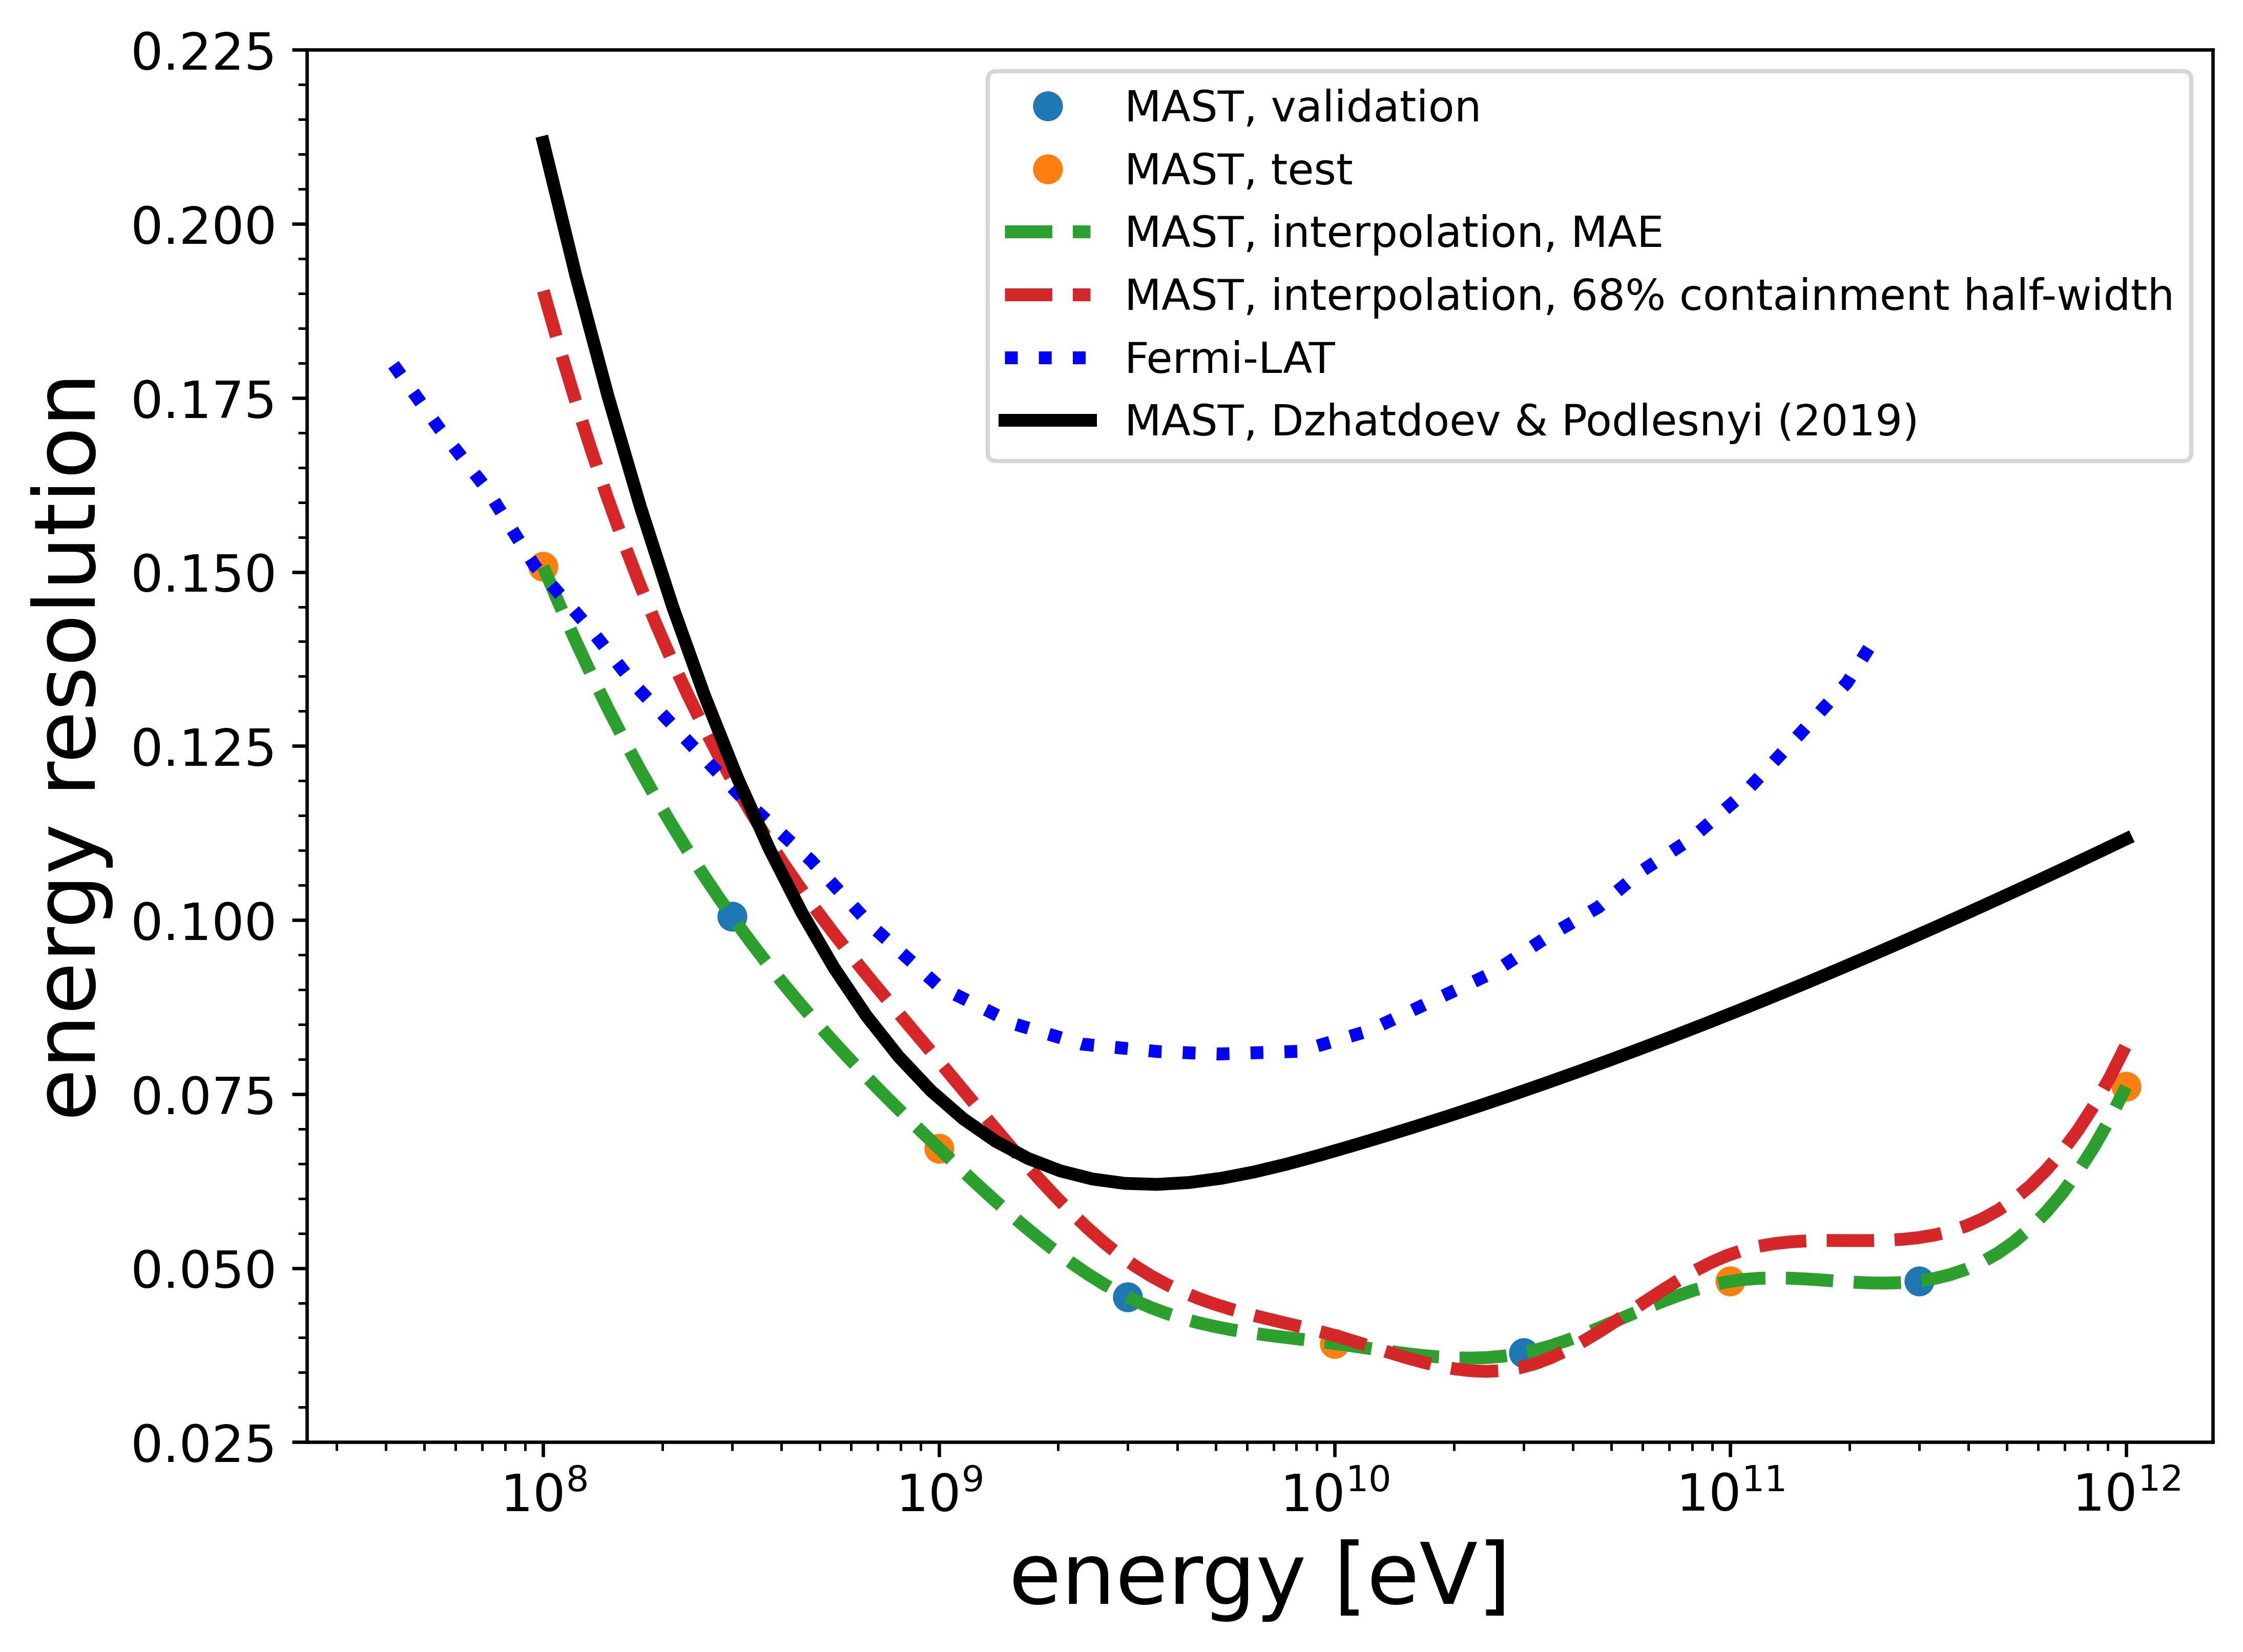

In [51]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

plt.plot(
    validation_energies, energy_resolution_validation,
    marker='o',
    linewidth=0,
    label='MAST, validation'
)

plt.plot(
    train_energies, energy_resolution_test,
    marker='o',
    linewidth=0,
    label='MAST, test'
)

plt.plot(
    np.logspace(8, 12, 100), energy_resolution_interpolated(np.logspace(8, 12, 100)),
    linestyle='--',
    linewidth=3,
    label='MAST, interpolation, MAE'
)

plt.plot(
    np.logspace(8, 12, 100), en68_interpolated(np.logspace(8, 12, 100)),
    linestyle='--',
    linewidth=3,
    label='MAST, interpolation, 68% containment half-width'
)

plt.plot(
    energy_resolution_fermi[:, 0], energy_resolution_fermi[:, 1],
    marker=None,
    linestyle=':',
    linewidth=3,
    label='Fermi-LAT',
    color='b'
)

plt.plot(
    energy_resolution_old[:, 0], energy_resolution_old[:, 1],
    marker=None,
    linestyle='-',
    linewidth=3,
    label='MAST, Dzhatdoev & Podlesnyi (2019)',
    color='k'
)


plt.xlabel('energy ' + '[eV]', fontsize=20)
plt.xticks(fontsize=12)
plt.ylabel('energy resolution', fontsize=20)
plt.yticks(fontsize=12)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xscale('log')
plt.ylim(0.025, 0.225)
# ax.set_yscale('log')
plt.legend(fontsize=10) 
plt.show()
# fig.savefig('NN_energy_resolution_v9-course_work.pdf')
# fig.savefig('NN_energy_resolution_v9-course_work.png')